In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import keras.models
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
c_dir = os.getcwd()

relative_burst_dir = os.path.join('data', 'burst')
relative_nburst_dir = os.path.join('data', 'no_burst')

burst_image_dir = os.path.join(c_dir, relative_burst_dir)
nburst_image_dir = os.path.join(c_dir, relative_nburst_dir)
target_size = (256, 256)

print(burst_image_dir)
print(nburst_image_dir)

c:\Users\bbaki\Desktop\fhnw\Scripts\radio_sunburst_detector\data\burst
c:\Users\bbaki\Desktop\fhnw\Scripts\radio_sunburst_detector\data\no_burst


In [7]:
def resize_and_fill(image_path, target_size):
    img = Image.open(image_path)
    img.thumbnail(target_size)

    new_img = Image.new("L", target_size)
    new_img.paste(img, ((target_size[0] - img.size[0]) // 2,
                        (target_size[1] - img.size[1]) // 2))

    return new_img

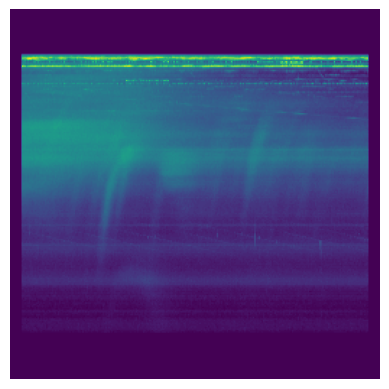

In [8]:
for file_name in os.listdir(burst_image_dir):
    #print(file_name)
    if file_name.endswith('.png'):
        image_path = os.path.join(burst_image_dir, file_name)
        new_img = resize_and_fill(image_path, target_size)
        new_img.save(os.path.join(burst_image_dir, file_name)) #save new image
        
plt.imshow(new_img)
plt.axis("off")
plt.show()

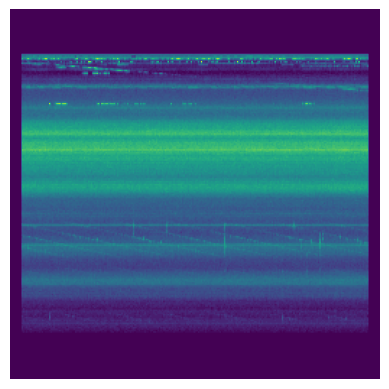

In [9]:
for file_name in os.listdir(nburst_image_dir):
    #print(file_name)
    if file_name.endswith('.png'):
        image_path = os.path.join(nburst_image_dir, file_name)
        new_img = resize_and_fill(image_path, target_size)
        new_img.save(os.path.join(nburst_image_dir, file_name)) #save new image
        
plt.imshow(new_img)
plt.axis("off")
plt.show()

In [12]:
directory = os.path.join(c_dir, 'data')
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="grayscale",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42, #can change
    validation_split=0.2, #can change
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="grayscale",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42, #can change
    validation_split=0.2, #can change
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)





Found 100 files belonging to 2 classes.


Using 80 files for training.
Found 100 files belonging to 2 classes.
Using 20 files for validation.


In [13]:
#rescale training and validation data
def rescale(image, label):
    return image/255. , label

train_ds = train_ds.map(rescale)
validation_ds = validation_ds.map(rescale)

In [14]:
#Determine the number of images in train and validation datasets
train_total_size = tf.data.experimental.cardinality(train_ds).numpy()
val_total_size = tf.data.experimental.cardinality(validation_ds).numpy()

print("Training data Image number: ", train_total_size)
print("Validation data Image number: ", val_total_size)

Training data Image number:  3
Validation data Image number:  1


In [15]:
#Fix the random generator seeds for better reproducibility
tf.random.set_seed(67)
np.random.seed(67)

In [16]:
#Class to build the Model
class Model_builder:
        def __init__(self, input_shape, num_classes):
            self.input_shape = input_shape
            self.num_classes = num_classes
            self.model = None
        def build(self):

        

            input_img = Input(shape=self.input_shape)
            #inputs_repeated = tf.keras.layers.Concatenate(axis=-1)([input_img, input_img, input_img])
            x= input_img
            # AUTOENCODER: how stacked should it be/How many layers? 
            #1st layer
            for _ in range(3):
                x = Conv2D(
                    filters=3,
                    kernel_size=3, #could be changed manually
                    activation='relu',
                    padding='same',
                    activity_regularizer=regularizers.l1(0.00001),
                    kernel_initializer='he_normal'
                )(x)
                x = MaxPooling2D((2, 2), padding='same')(x) #max pooling layer

            #max pooling layer to give us the result of the encoding process: latent space
            x = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
            encoded = Conv2D(3, (1, 1), activation='relu')(x)
            print(encoded.shape)

             #MODEL1   
            x = tf.keras.layers.Flatten()(encoded)
            x = tf.keras.layers.Dense(128, activation='relu')(x)
            x = tf.keras.layers.Dropout(0.3)(x)
            output = tf.keras.layers.Dense(1, activation='sigmoid')(x)   
             
             
             #MODEL2   
            #flattened = tf.keras.layers.Flatten()(encoded)
            #dense_1 = tf.keras.layers.Dense(1000, activation='relu')(flattened)
            #dense_2 = tf.keras.layers.Dense(100, activation='relu')(dense_1)
            #output = tf.keras.layers.Dense(1, activation='sigmoid')(dense_2)
                   
                        
                        
                        #start of decoding, remove comment for decoding
                        #x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
                        #x = UpSampling2D((2, 2))(x)
                        #x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
                        #x = UpSampling2D((2, 2))(x)
                        #decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


             #PRETRAINED EFFICIENTNET 
            #could possibly use smaller but less computationaly expensive models: try,
            #note that use of LSTM is computationally more expensive and is not sure to bring better accuracy but still worth trying 
            #also note the use of tranfer learning here, but could also go with the route of training the whole model: after HP tuning with validation data ofc
            #reduced_channels = Conv2D(3, (1, 1))(encoded)
            #upsampled = tf.keras.layers.UpSampling2D(size=(28,28))(reduced_channels)
            #efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
            #for i, layer in enumerate(efficientnet.layers):
                #print(i, layer.name)
            #normalization_layer = efficientnet.layers[2]
            #x = normalization_layer(encoded)
            #efficientnet_without_norm = Model(efficientnet.input, efficientnet.layers[-1].output)
            #for layer in efficientnet.layers[:-20]:  #freezing everything except top 20 layers, again could also go for layer.trainable=true for all layers: do we have enough computational resources?
             #   layer.trainable = False
            #x = efficientnet(encoded) #!!!!!!!!!!!!!!!!!!!!!!!change to encoded, change dimensions in other places accordingly
            #x = GlobalAveragePooling2D()(x) #helps reduce overfitting by reducing the total number of parameters in the model
            #x = Dense(3,kernel_initializer='glorot_uniform')(x) #A fully connected dense layer, possibly for feature extracion, could think of adding more layers here for feature classifications in the future
            #x = Dropout(0.3)(x)#for regularization, again use of tuning: maybe too much?
            
            #output = Dense(1, activation='sigmoid')(x)#fully connected dense layer with softmax activation for producing the output probabilities of classes
                #This works as the classifier in our ML pipeline thanks to softmax
            #output = Conv2D(3, (1, 1))(x)

            #create the model using keras Model function with all the earlier configuration and return it
            self.model = tf.keras.models.Model(inputs=input_img, outputs=output)

        
        #compile the model
        def compile(self):
            self.model.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy']
            )
            return self.model
            
        

In [36]:
#Create a model_builder object, build and compile the model inside it and retrieve it as "model"
model_builder_object = Model_builder(input_shape=(256, 256, 1) ,num_classes=2)#this part can be replaced with correct input shape: 
model_builder_object.build() 
model = model_builder_object.compile()
 


(None, 32, 32, 3)


In [37]:
#Train the model
model.fit(
    train_ds,
    validation_data=(validation_ds),
    epochs=20,
    batch_size=32,
)

Epoch 1/20


3/3 [==============================] - 3s 413ms/step - loss: 2.1999 - accuracy: 0.5625 - val_loss: 2.2733 - val_accuracy: 0.6000
Epoch 2/20
3/3 [==============================] - 1s 294ms/step - loss: 2.1020 - accuracy: 0.5750 - val_loss: 2.2603 - val_accuracy: 0.5500
Epoch 3/20
3/3 [==============================] - 1s 278ms/step - loss: 2.0414 - accuracy: 0.6000 - val_loss: 2.2054 - val_accuracy: 0.5500
Epoch 4/20
3/3 [==============================] - 1s 302ms/step - loss: 1.9450 - accuracy: 0.6875 - val_loss: 2.1147 - val_accuracy: 0.6500
Epoch 5/20
3/3 [==============================] - 1s 285ms/step - loss: 1.9287 - accuracy: 0.6500 - val_loss: 2.0753 - val_accuracy: 0.6000
Epoch 6/20
3/3 [==============================] - 1s 277ms/step - loss: 1.8528 - accuracy: 0.7875 - val_loss: 2.0433 - val_accuracy: 0.5500
Epoch 7/20
3/3 [==============================] - 1s 286ms/step - loss: 1.8073 - accuracy: 0.6750 - val_loss: 2.0375 - val_accuracy: 0.6000
Epoch 8/20
3/3 [===============